## **Environment Setup**
Run all when initiating session

In [1]:
# retrieve config file, if using colab (nothing should happen if you use Windows)
!cp './drive/My Drive/Live Workspace/generative-facial-cosmetics/encoder_engineering/config.py' '.'
!mkdir data
!cp -a './drive/My Drive/Live Workspace/generative-facial-cosmetics/encoder_engineering/data/' '.'
!mkdir models
!cp -a './drive/My Drive/Live Workspace/generative-facial-cosmetics/encoder_engineering/models/' '.'
!mkdir technical
!cp -a './drive/My Drive/Live Workspace/generative-facial-cosmetics/encoder_engineering/technical/' '.'
!mkdir utils
!cp -a './drive/My Drive/Live Workspace/generative-facial-cosmetics/encoder_engineering/utils/' '.'

'cp' is not recognized as an internal or external command,
operable program or batch file.
A subdirectory or file data already exists.
'cp' is not recognized as an internal or external command,
operable program or batch file.
A subdirectory or file models already exists.
'cp' is not recognized as an internal or external command,
operable program or batch file.
A subdirectory or file technical already exists.
'cp' is not recognized as an internal or external command,
operable program or batch file.
A subdirectory or file utils already exists.
'cp' is not recognized as an internal or external command,
operable program or batch file.


In [2]:
from config import *                            # config.py
from matplotlib import pyplot as plt 
import os
%matplotlib inline

## **GCS Integration**
Run all when initiating session

In [3]:
if isWindows():
  import utils.gcs_windows as gcs 
elif isColab():
  import utils.gcs_colab as gcs
else:
  raise NotImplementedError('OS is not supported yet')

if isColab():
  gcs.init()
# no need of buckets for this project

## **Model Environment Setup**

In [4]:
### tf-side debug ###
# more info: https://github.com/tensorflow/tensorflow/issues/29931
import tensorflow as tf
temp = tf.zeros([2, 16, 16, 3])  # Or tf.zeros
tf.keras.applications.vgg16.preprocess_input(temp)
print('')

In [5]:
from data.pipeline import *
from technical.accelerators import strategy
from utils.generator_loading_utils import load_generator_checkpoint
from utils.encoder_loading_utils import load_encoder_checkpoint
from utils.face_utils import detect_and_crop_lips, replace_lips

Running on CPU
Number of accelerators (cores):  1


In [6]:
##### Create and load saved generator here (checkpoint) #####
# please put generator's saved checkpoint in OUTPUT/generator_checkpoints (GCS for colab)
RUN = True
if RUN:
  generator = load_generator_checkpoint(strategy, model_type='256')
  print(generator)
else:
  print("Running switch for this cell is off, skipping")

r.layer_with_weights-1.kernel


In [7]:
##### Create and load saved encoder here (checkpoint) #####
# please put encoder's saved checkpoint in OUTPUT/encoder_checkpoints (GCS for colab)
RUN = True
if RUN:
  encoder = load_encoder_checkpoint(strategy)
  print(encoder)
else:
  print("Running switch for this cell is off, skipping")

Model: "modified-vgg16-encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 360, 360, 4)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 360, 360, 32)      1184      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 360, 360, 32)      0         
_________________________________________________________________
average_pooling2d (AveragePo (None, 180, 180, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 180, 180, 64)      18496     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 180, 180, 64)      0         
_________________________________________________________________
average_pooling2d_1 (Average (None, 90, 90, 

In [8]:
LATENT_SIZE = encoder.model.layers[-1].output.shape[1:] 
IMAGE_SHAPE = encoder.model.layers[0].output.shape[1:] 
IMAGE_SIZE = [IMAGE_SHAPE[0], IMAGE_SHAPE[0]]
print("Latent size: " + str(LATENT_SIZE))
print("Image shape: " + str(IMAGE_SHAPE))

Latent size: (256,)
Image shape: (360, 360, 4)


## **Testing**

In [51]:
import numpy as np
import os

In [52]:
## input
img_name = 'test_2.png'
img_path = os.path.join(DIR, os.path.join('samples', img_name))
img = load_image(img_path)
#plt.imshow(img[:, :, [2, 1, 0]])

In [53]:
## crop
cropped_lips, p_data = detect_and_crop_lips(img_full=img)
cropped_lips = np.array(cropped_lips)/255
#plt.imshow(cropped_lips)

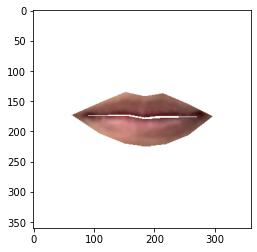

In [54]:
resized = cropped_lips #cv2.resize(cropped_lips, dsize=(90, 90), interpolation=cv2.INTER_CUBIC)
plt.imshow(resized)

In [55]:
## Encode the cropped lips
encoded = encoder.model(np.expand_dims(resized, 0))
#print(encoded)

Visual loss: 0.006504554767161608


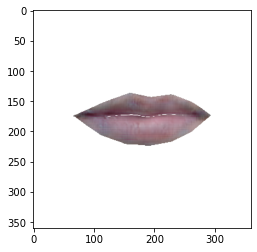

In [56]:
## Regeneration (w/o injections)
regenerated = generator.model(encoded, training=False)[0]
plt.imshow(regenerated)
print("Visual loss: " + str(float(tf.keras.losses.MSE(tf.keras.backend.flatten(resized), tf.keras.backend.flatten(regenerated)))))

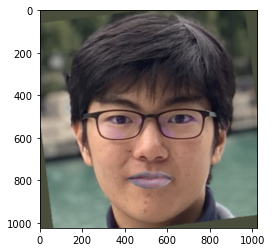

In [57]:
## Replacement
#img = cv2.resize(img, dsize=(90, 90), interpolation=cv2.INTER_CUBIC)
new_img = replace_lips(regenerated.numpy(), p_data, img_full=img)

In [58]:
injectible = generator.get_injectible_model(strategy)
inputs = injectible.inputs
for layer in inputs:
  print(layer.name)

Model: "generator-256-5-i"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 256)]        0                                            
__________________________________________________________________________________________________
dense_15 (Dense)                (None, 256)          65792       input_5[0][0]                    
                                                                 256_input[0][0]                  
                                                                 128_input[0][0]                  
                                                                 64_input[0][0]                   
                                                                 32_input[0][0]                   
                                                                 16_input[0][0]   

In [59]:
## Load to-be-injected image
img2_name = 'purple_lips.png'
img2_path = os.path.join(DIR, os.path.join('samples', img2_name))
img2 = load_image(img2_path)

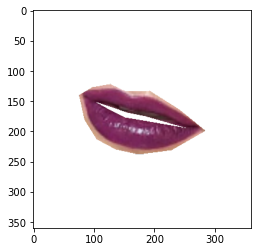

In [60]:
## Crop to-be-injected image
cropped_lips2, p_data2 = detect_and_crop_lips(img_full=img2)
cropped_lips2 = np.array(cropped_lips2)/255
plt.imshow(cropped_lips2)

In [61]:
## Encode the cropped lips
encoded2 = encoder.model(np.expand_dims(cropped_lips2, 0))
#print(encoded2)

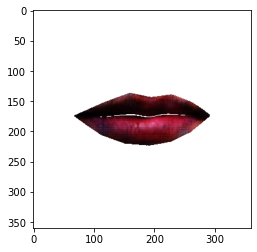

In [68]:
## Regeneration (w/ injections)
regenerated_mix = injectible([encoded, encoded, encoded, encoded, encoded, encoded, encoded2*3], training=False)[0]
plt.imshow(regenerated_mix)

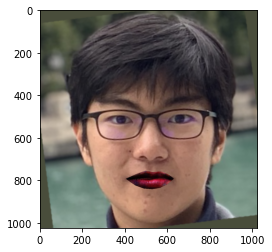

In [69]:
## Replacement
new_img = replace_lips(regenerated_mix.numpy(), p_data, img_full=img)

## **Experiments**
Just a playground for trying out codes, nothing related at all, do not execute

In [ ]:
img_pil = Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGBA))
plt.imshow(img_pil)

In [ ]:
min_x, min_y, max_x, max_y, offset_x, offset_y = p_data
cropped_lips_pil = Image.fromarray((cropped_lips*255).astype('uint8'))
cropped_lips_pil = cropped_lips_pil.crop((offset_x, offset_y, offset_x+(max_x-min_x), offset_y+(max_y-min_y)))
img_pil = Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGBA))
img_pil.paste(cropped_lips_pil, (min_x, min_y), cropped_lips_pil)
plt.imshow(img_pil)

In [ ]:
min_x, min_y, max_x, max_y, offset_x, offset_y = p_data
img_tmp = (cropped_lips*255).astype('uint8')
cropped_lips_pil = Image.fromarray(img_tmp)
cropped_lips_pil = cropped_lips_pil.crop((offset_x, offset_y, offset_x+(max_x-min_x), offset_y+(max_y-min_y)))
plt.imshow(cropped_lips_pil)